# Final Project Submission

In [61]:
# Please fill out:
# * Student name: Sabina Bains
# * Student pace: Self Paced
# * Scheduled project review date / time: ??????
# * Instructor name: Claude Fried

Business Problem:

King County Healing Association (KCHA) has reached out to you to help get previously incarcerated individuals get back on their feet.

KCHA is an established nonprofit organization that has a variety of successful initiatives such as rehabilitation centers, medical assistance, career services, and temporary housing for those re-entering their communities. The organization now wants to expand on their housing opportunities by rolling out a new service to help those who are prepared to transition into a permanent residence.  

KCHA plans to work with aspiring homeowners in their program towards choosing a quality, yet affordable home. From there, KCHA purchases the home and rents it out to the tenant until fully paid off. There are multiple conditions in the contract, including having held a full time job for at least a year, having a household salary that is at least 30% of the house price, and choosing a home in the same zipcode as their parole officer, if applicable.

KCHA doesn't plan to launch this service for another 3 years, however they first need to determine whether their budget can even cover this program. To do this, they want us to create a model (similar to Zillow's 'Zestimates') that can predict the price for homes of various size and location that are not yet on the market

------

Business Problem:

King County Homeless Association (KCHA) has reached out to you to help get those in need back their feet. 

KCHA is an established nonprofit organization that has a variety of successful initiatives such as rehabilitation centers, medical assistance, childcare, and career services.

They also offer emergency shelters for those sleeping in spaces not habitable for humans, as well as temporary housing for multiple families to occupy for a flexible time period. The organization now wants to expand on their housing opportunities by rolling out a new service to help those who are prepared to transition into a permanent residence. 

KCHA plans to work with aspiring homeowners in the program towards choosing a quality, yet affordable home. From there, KCHA purchases the home and rents it out to the tenant until fully paid off. There are multiple conditions in the contract, including having held a full time job for at least a year, having a household salary that is at least 30% of the house price, and choosing a home in the same zipcode as their place of residence. 

KCHA doesn't plan to launch this service for another 3 years, however they first need to determine whether their donations can even cover this program. To do this, they want us to create a model (similar to Zillow's 'Zestimates') that can predict the price the 6 families they estimate will use their service once it launches. 




### Importing Packages and Reading in Data

In [62]:
# importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import numpy as np
# plt.style.use('ggplot')

style.use('dark_background')
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)

In [63]:
# importing King County House Sales dataset
df = pd.read_csv('data/kc_house_data.csv')

# Data Exploration

### Handling N/A's

In [64]:
df.describe()
len(df)

print('''
This data set is comprised of {} rows.
N/A's:
{}
'''.format(len(df),df.isna().sum()))


This data set is comprised of 21597 rows.
N/A's:
id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64



In [65]:
## checking waterfront column
print('''Unique values are {} removing waterfront N/A's would remove {} of the overall dataset. We can drop this column from the dataset since we 
are looking at affordable homes, and a waterfront property is not a priority'''
      .format(df.waterfront.unique(), '{:0.1%}'.format(df.waterfront.isna().sum() / len(df))))

Unique values are [nan  0.  1.] removing waterfront N/A's would remove 11.0% of the overall dataset. We can drop this column from the dataset since we 
are looking at affordable homes, and a waterfront property is not a priority


In [66]:
## dropping waterfront columns
df.drop('waterfront',axis=1,inplace=True)

In [67]:
## dropping view columns as well
df.drop('view',axis=1,inplace=True)

In [69]:
## checking yr_renovated column
print('''removing view N/A's would remove {} of the overall dataset. Let's assume n/a means no renovations.'''
      .format('{:0.1%}'.format(df.yr_renovated.isna().sum() / len(df))))

removing view N/A's would remove 17.8% of the overall dataset. Let's assume n/a means no renovations.


In [70]:
## filling yr_renovated NAs with 0
df.yr_renovated.fillna(0,inplace=True)

In [71]:
## Deleting rows with price > 1MM , as KCHA will not purchase above that price
df = df.loc[df.price < 1000000]

In [72]:
# Investigating Duplicate ID's

In [73]:
dup_id_list = df.loc[df.id.duplicated()]['id'].to_list()
dup_id_df = df.loc[df.id.isin(dup_id_list)]
dup_id_df_sort = dup_id_df.sort_values(by=['id','date'],ascending = False)
# Looks like these ID's are for updates in price. Keep them.

### Handling Data Types

In [74]:
df.info()

print('''-------------- NOTES: ---------------
id should be str
sqft_basement should be int or float
zipcode should be str
''')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20107 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20107 non-null  int64  
 1   date           20107 non-null  object 
 2   price          20107 non-null  float64
 3   bedrooms       20107 non-null  int64  
 4   bathrooms      20107 non-null  float64
 5   sqft_living    20107 non-null  int64  
 6   sqft_lot       20107 non-null  int64  
 7   floors         20107 non-null  float64
 8   condition      20107 non-null  int64  
 9   grade          20107 non-null  int64  
 10  sqft_above     20107 non-null  int64  
 11  sqft_basement  20107 non-null  object 
 12  yr_built       20107 non-null  int64  
 13  yr_renovated   20107 non-null  float64
 14  zipcode        20107 non-null  int64  
 15  lat            20107 non-null  float64
 16  long           20107 non-null  float64
 17  sqft_living15  20107 non-null  int64  
 18  sqft_l

In [75]:
## Removing sqft_basement with "?"
df = df.loc[~(df.sqft_basement == '?')]

In [76]:
# changing columns to str type
for col in ['id', 'zipcode']:
    df[col] = df[col].astype(str)

In [77]:
# changing columns to int type
for col in ['id', 'price', 'bedrooms', 'sqft_living',
       'sqft_lot', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']:
    df[col] = df[col].astype(float).astype(int)

In [78]:
df.info()
print('''------- notes: ---------
Everything looks good now''')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19683 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19683 non-null  int64  
 1   date           19683 non-null  object 
 2   price          19683 non-null  int64  
 3   bedrooms       19683 non-null  int64  
 4   bathrooms      19683 non-null  float64
 5   sqft_living    19683 non-null  int64  
 6   sqft_lot       19683 non-null  int64  
 7   floors         19683 non-null  float64
 8   condition      19683 non-null  int64  
 9   grade          19683 non-null  int64  
 10  sqft_above     19683 non-null  int64  
 11  sqft_basement  19683 non-null  int64  
 12  yr_built       19683 non-null  int64  
 13  yr_renovated   19683 non-null  int64  
 14  zipcode        19683 non-null  object 
 15  lat            19683 non-null  float64
 16  long           19683 non-null  float64
 17  sqft_living15  19683 non-null  int64  
 18  sqft_l

In [79]:
print('not interested in renovating details so will drop from our columns, as well as lat / long, ')

not interested in renovating details so will drop from our columns, as well as lat / long, 


In [118]:
#SPLITTING INTO CONTINOUS AND DISCRETE VARIABLES
cont = df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated']]
cat = df[['zipcode']]

In [119]:
# removing outlier with 33 bedrooms
cont = cont.loc[~(cont.bedrooms == 33)]

#### CHECKING LINEARITY OF PREDICTORS

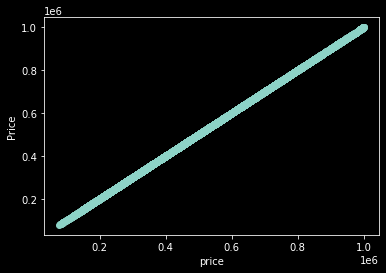

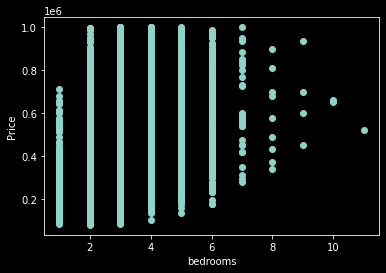

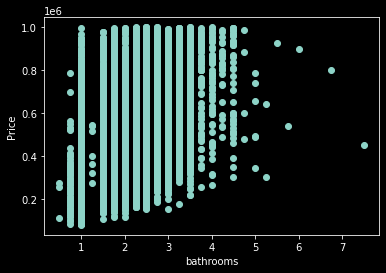

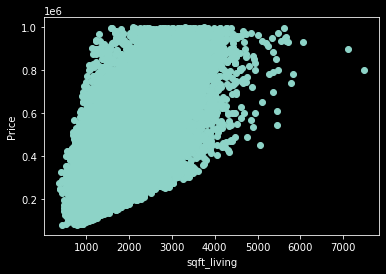

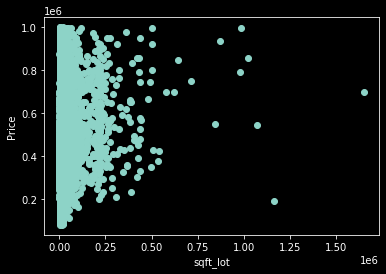

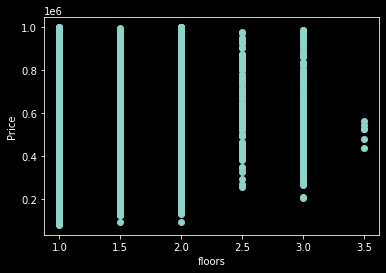

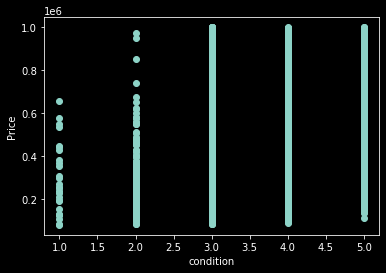

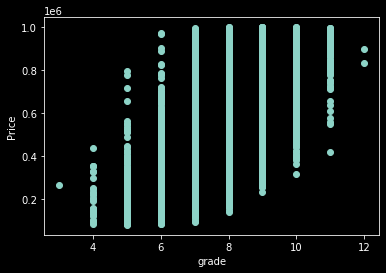

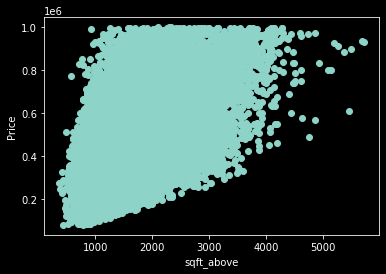

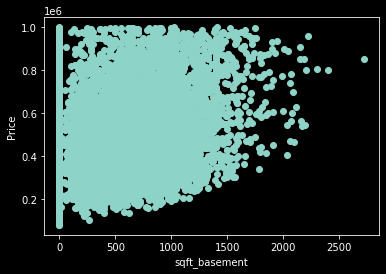

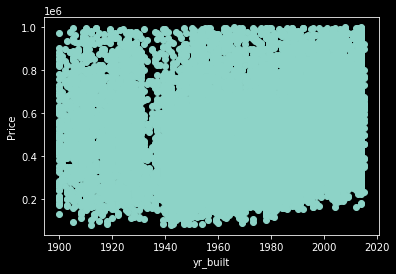

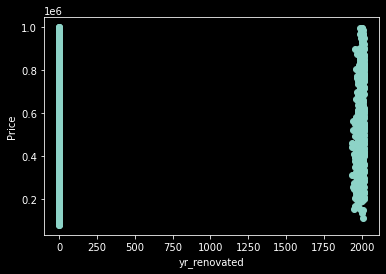


----------- NOTES: ------------
sqft_lot is not linear - lets remove
sqft_basement seems off (should be Y/N variable?)
yr_built is not linear
yr_renovated is not linear (should be Y/N variable?)
we can use grade to determine quality rather than condition since it is more linear



In [120]:
# #Checking Linearity of Predictors to Dependent variable
for col in cont.columns:
    plt.scatter(cont[col],cont['price'])
    plt.xlabel(col)
    plt.ylabel('Price')
#     plt.xlim([25, 50])
    plt.show()
    
print('''
----------- NOTES: ------------
sqft_lot is not linear - lets remove
sqft_basement seems off (should be Y/N variable?)
yr_built is not linear
yr_renovated is not linear (should be Y/N variable?)
we can use grade to determine quality rather than condition since it is more linear
''')

In [83]:
# grade seems like a better predictor of quality than condition so lets drop condition. also drop floors because it does not look linear. 

In [122]:
## Turning sqft_basement and yr_renovated into binary variables
def make_binary(row):
    if row > 0:
        return 1
    if row == 0:
        return 0
    
cat['has_basement'] = cont['sqft_basement'].apply(make_binary)
cat['renovated'] = cont['yr_renovated'].apply(make_binary)
cat = cat.loc[cat.renovated.isin([0,1])]

<ipython-input-122-bd5d48a19964>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['has_basement'] = cont['sqft_basement'].apply(make_binary)
<ipython-input-122-bd5d48a19964>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['renovated'] = cont['yr_renovated'].apply(make_binary)


In [123]:
## dropping vars that do not pass assumption, and adding new dummy vars into x_cat
cont.drop(['sqft_lot','sqft_basement','yr_renovated','yr_built','condition','floors'],axis=1,inplace=True)

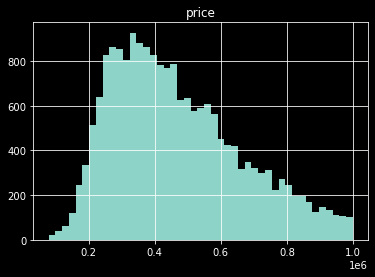

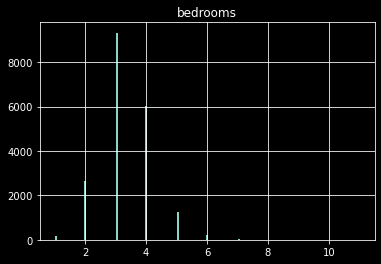

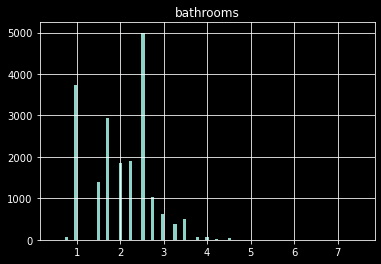

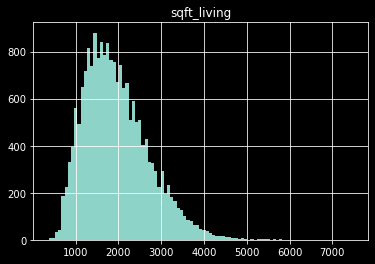

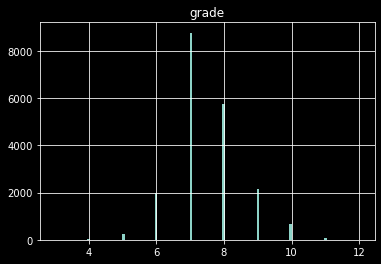

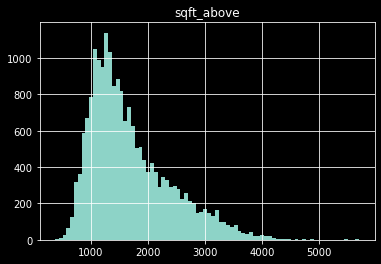

In [124]:
## Checking Normality of Variables ( Not an assumption, but just for reference )
## Variables seem skewed

for col in cont.columns:
    cont.hist(col,bins='auto')

#### CHECKING FOR NORMAL DISTRIBUTION OF RESIDUALS AND HOMOSCEDASTICITY

bedrooms [('Jarque-Bera', 1120.8840582738123), ('Prob', 4.009768679085295e-244), ('Skew', 0.5629293929964159), ('Kurtosis', 2.684984332658935)]
bathrooms [('Jarque-Bera', 1108.2503801314388), ('Prob', 2.2206886396995917e-241), ('Skew', 0.5743118115743101), ('Kurtosis', 2.820971259195855)]
sqft_living [('Jarque-Bera', 722.7302585214504), ('Prob', 1.1511141959144137e-157), ('Skew', 0.46806636351164416), ('Kurtosis', 2.92968414420381)]
grade [('Jarque-Bera', 1018.7496701016344), ('Prob', 6.043936837208517e-222), ('Skew', 0.5525042676434662), ('Kurtosis', 3.145628082275768)]
sqft_above [('Jarque-Bera', 1006.8586335009414), ('Prob', 2.3090094319447268e-219), ('Skew', 0.5499100998201988), ('Kurtosis', 2.8652886817078342)]

--------- NOTES: ----------
None of these variables have normally distributed residuals.
    JB values are relatively large. x
    All values have a slight positive skew
    All values have Kurtosis values ~3, implying normal tails. 
None of these variables are Homoscedast

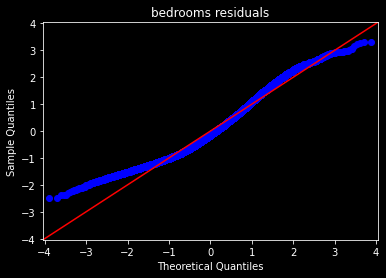

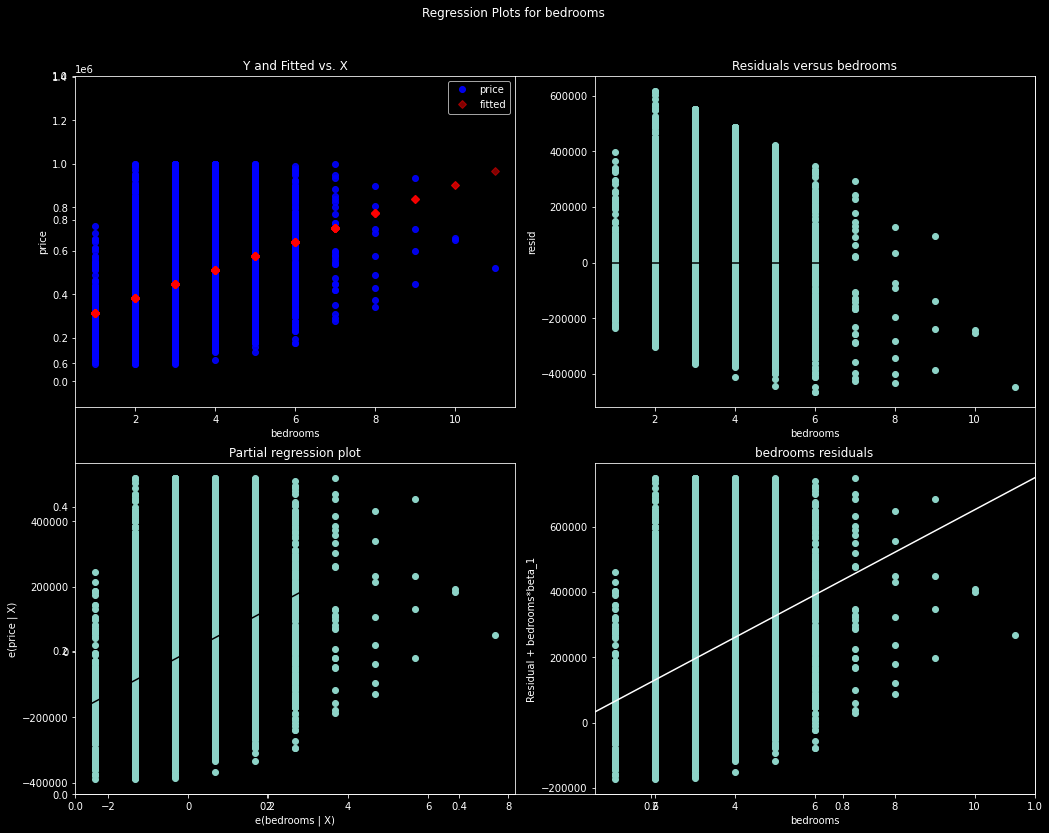

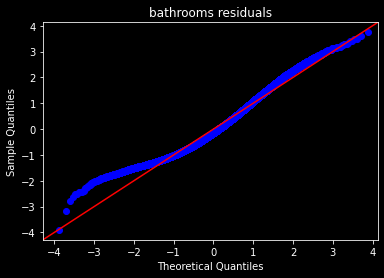

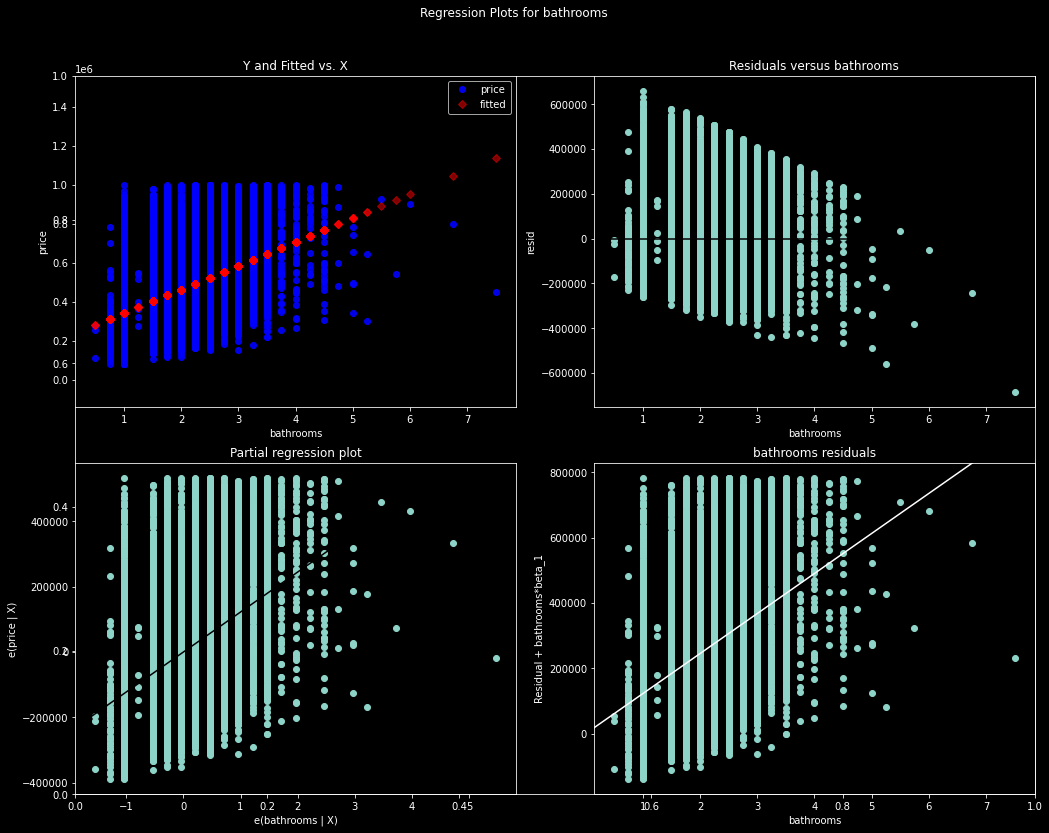

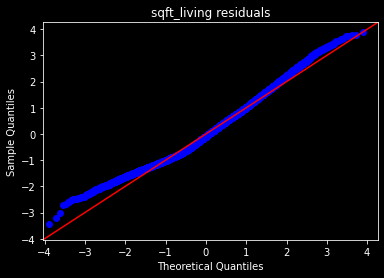

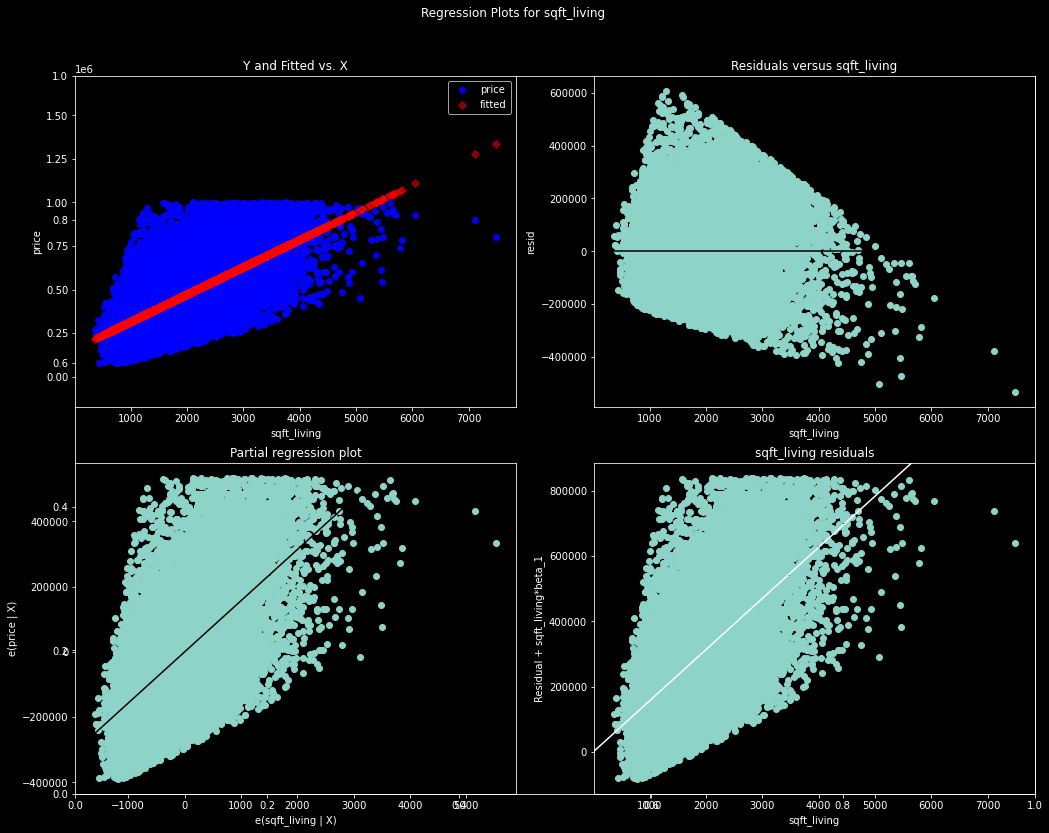

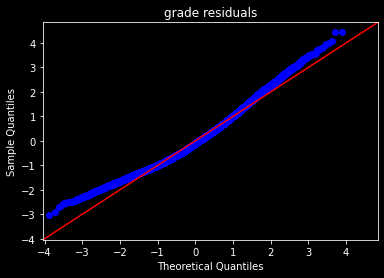

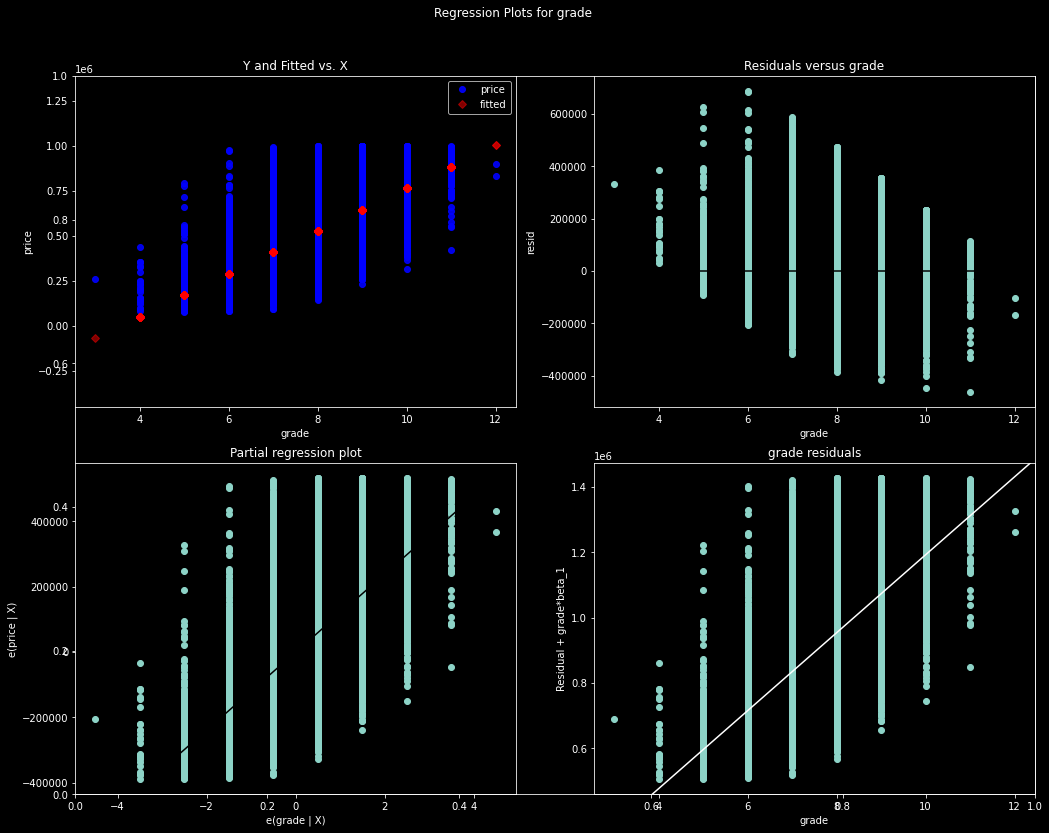

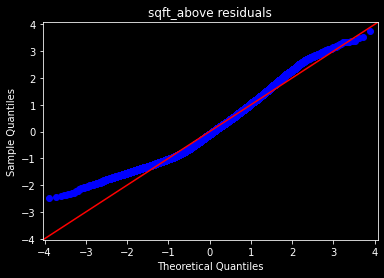

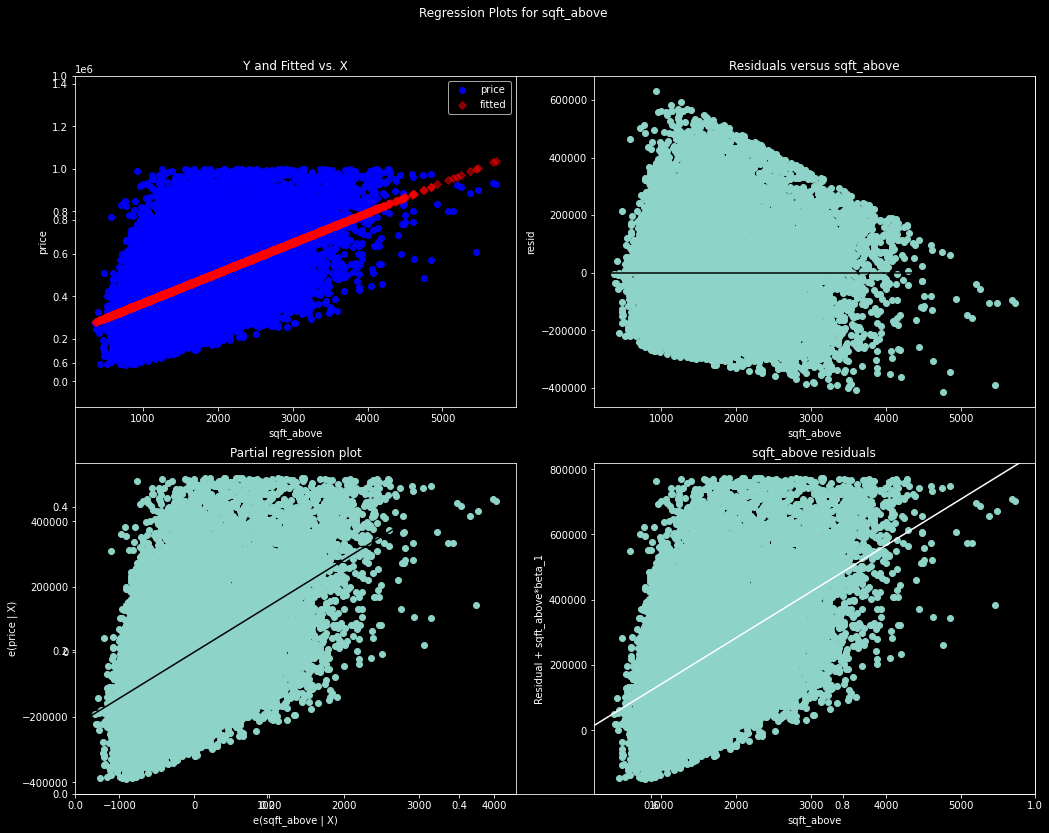

In [125]:
for col in cont.drop('price',axis=1):
    f = 'price ~ '+col
    model = smf.ols(formula=f, data=cont).fit()
    resid = model.resid
    fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)
    plt.title(col+' residuals')
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.title(col+' residuals')
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(model.resid)
    print(col, list(zip(name, test)))
    
print('''
--------- NOTES: ----------
None of these variables have normally distributed residuals.
    JB values are relatively large. x
    All values have a slight positive skew
    All values have Kurtosis values ~3, implying normal tails. 
None of these variables are Homoscedastic

*****We will have to transform this data*****
''')

In [126]:
## these all seem relatively normally distributed

In [127]:
df_corr = cont.corr().abs().stack().reset_index().sort_values(by=0,ascending=False)
df_corr.loc[(df_corr['level_0'] == 'price') & (df_corr[0] != 1)]

,level_0,level_1,0
4,price,grade,0.616879
3,price,sqft_living,0.604522
5,price,sqft_above,0.515814
2,price,bathrooms,0.439215
1,price,bedrooms,0.293125


#### FEATURE SCALING AND NORMALIZATION?

In [128]:
# acc = data_pred['acceleration']
# logdisp = data_log['logdisp']
# loghorse = data_log['loghorse']
# logweight = data_log['logweight']

# scaled_acc = (acc - min(acc)) / (max(acc) - min(acc))
# scaled_disp = (logdisp - np.mean(logdisp)) / np.sqrt(np.var(logdisp))
# scaled_weight = (logweight - np.mean(logweight)) / np.sqrt(np.var(logweight))
# scaled_horse = (loghorse - np.mean(loghorse)) / (max(loghorse) - min(loghorse))

# data_cont_scaled = pd.DataFrame([])
# data_cont_scaled['acc'] = scaled_acc
# data_cont_scaled['disp'] = scaled_disp
# data_cont_scaled['horse'] = scaled_horse
# data_cont_scaled['weight'] = scaled_weight

# data_cont_scaled.hist(figsize = [6, 6]);


### Do we need to do feature scaling / normalization?


##### HANDLING CATEGORICAL VARIABLES

In [129]:
# checking out how many unique values are in each cat value
for col in cat.columns:
    print(cat[col].unique())

['98178' '98125' '98028' '98136' '98074' '98198' '98146' '98038' '98007'
 '98115' '98107' '98126' '98019' '98103' '98003' '98133' '98092' '98030'
 '98002' '98119' '98112' '98052' '98027' '98117' '98058' '98001' '98056'
 '98166' '98023' '98148' '98105' '98042' '98008' '98059' '98122' '98144'
 '98004' '98034' '98075' '98116' '98118' '98040' '98032' '98045' '98102'
 '98077' '98108' '98168' '98177' '98065' '98029' '98006' '98109' '98022'
 '98033' '98155' '98024' '98011' '98053' '98031' '98010' '98106' '98070'
 '98199' '98072' '98188' '98005' '98014' '98055' '98039']
[0. 1.]
[0. 1.]


In [130]:
cat_dummies_list = []
for idx, col in enumerate(cat.columns):
    cat_dummies_list.append(pd.get_dummies(cat[col], prefix=col, drop_first=True))
    
cat_dummies = pd.concat(cat_dummies_list, axis=1)

In [131]:
cat_dummies

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,has_basement_1.0,renovated_1.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
21595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### CHECKING FOR MULTICOLLINEARITY

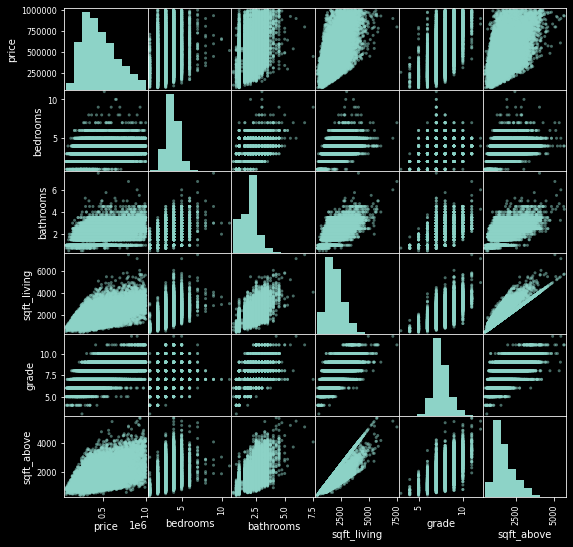

In [132]:
## Looking at relationship between remaining continuous variables 
pd.plotting.scatter_matrix(cont,figsize  = [9, 9]);
plt.show()

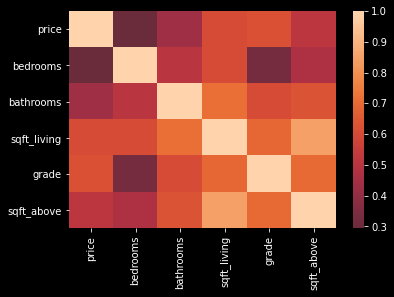

In [133]:
# Another view. shows sqft_living and sqft_above highly correlated which makes sense. 
sns.heatmap(cont.corr(), center=0);

In [134]:
# Viewing Correlation Between Each Variable ad Checking which variables have a correlation > 0.75 as this could suggest multicollinearity
cont_corr = cont.corr().abs().stack().reset_index()
cont_corr['preds'] = cont_corr['level_0']+' & '+cont_corr['level_1']
cont_corr = cont_corr.drop(['level_0','level_1'],axis = 1).rename(columns={0:'corr'}).sort_values(by='corr',ascending = False)
cont_corr.loc[(cont_corr['corr'] > 0.75) & (cont_corr['corr'] != 1)]

,corr,preds
33,0.850052,sqft_above & sqft_living
23,0.850052,sqft_living & sqft_above


In [135]:
## Looks like sqft_living is what is correlating with each predictor. Lets drop this. 
cont.drop('sqft_living',axis=1,inplace=True)

In [136]:
#Creating Final Dataset

In [137]:
final_preds = pd.concat([cat_dummies,cont.drop('price',axis=1)], axis = 1)

In [138]:
# df.groupby(by='zipcode').mean().sort_values(by='price',ascending=False)['price'].astype(int)

#### Running the model

In [140]:


predictors_int = sm.add_constant(final_preds)
model = sm.OLS(cont['price'],predictors_int).fit()
model.summary() # Rs of 0.821

# predictors_int = sm.add_constant(final_preds.drop(['bedrooms_33','floors_3.5','grade_10','zipcode_98022'],axis=1))
# model = sm.OLS(df['price'],predictors_int).fit()
# model.summary() # Rs of 0.821

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     969.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:16:10   Log-Likelihood:            -2.5248e+05
No. Observations:               19682   AIC:                         5.051e+05
Df Residuals:                   19606   BIC:                         5.057e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.598e+05   7909.655    -32.849      0.000   -2.75e+05   -2.44e+05
zipcode_98002     9402.1294   8033.133      1.170      0.242   -6343.493    2.51e+04
zipcode_98003     3330.3812   7286.690      0.457      0.648    -1.1e+04    1.76e+04
zipcode_98004     5.114e+05   9206.279     55.549      0.000    4.93e+05    5.29e+05
zipcode_98005     3.574e+05   8986.884     39.769      0.000     3.4e+05    3.75e+05
zipcode_98006     2.986e+05   6749.276     44.246      0.000    2.85e+05    3.12e+05
zipcode_98007     2.662e+05   9233.177     28.830      0.000    2.48e+05    2.84e+05
zipcode_98008     2.633e+05   7398.259     35.594      0.000    2.49e+05    2.78e+05
zipcode_98010     1.045e+05   1.03e+04     10.122      0.000    8.43e+04    1.25e+05
zipcode_98011     1.483e+05   8122.862     18.253      0.000    1.32e+05    1.64e+05
zipcode_98014     1.349e+05   9588.162     14.064      0.000    1.16e+05    1.54e+05
zipcode_98019     1.001e+05   8180.319     12.240      0.000    8.41e+04    1.16e+05
zipcode_98022     4.685e+04   7679.647      6.100      0.000    3.18e+04    6.19e+04
zipcode_98023    -1.838e+04   6322.928     -2.907      0.004   -3.08e+04   -5988.274
zipcode_98024     1.759e+05   1.17e+04     15.047      0.000    1.53e+05    1.99e+05
zipcode_98027     2.025e+05   6722.352     30.129      0.000    1.89e+05    2.16e+05
zipcode_98028     1.417e+05   7285.498     19.450      0.000    1.27e+05    1.56e+05
zipcode_98029     2.213e+05   7159.836     30.913      0.000    2.07e+05    2.35e+05
zipcode_98030      581.2939   7467.293      0.078      0.938   -1.41e+04    1.52e+04
zipcode_98031     1.476e+04   7343.451      2.009      0.045     362.244    2.91e+04
zipcode_98032      541.7192   9469.150      0.057      0.954    -1.8e+04    1.91e+04
zipcode_98033     3.221e+05   6880.666     46.805      0.000    3.09e+05    3.36e+05
zipcode_98034     1.885e+05   6254.644     30.131      0.000    1.76e+05    2.01e+05
zipcode_98038     4.036e+04   6133.092      6.582      0.000    2.83e+04    5.24e+04
zipcode_98039     6.621e+05   4.07e+04     16.273      0.000    5.82e+05    7.42e+05
zipcode_98040     4.465e+05   8989.861     49.665      0.000    4.29e+05    4.64e+05
zipcode_98042     1.468e+04   6179.738      2.375      0.018    2564.625    2.68e+04
zipcode_98045     1.128e+05   7877.185     14.315      0.000    9.73e+04    1.28e+05
zipcode_98052     2.571e+05   6208.881     41.407      0.000    2.45e+05    2.69e+05
zipcode_98053     2.416e+05   6794.330     35.559      0.000    2.28e+05    2.55e+05
zipcode_98055     4.301e+04   7375.895      5.831      0.000    2.85e+04    5.75e+04
zipcode_98056     1.152e+05   6607.985     17.437      0.000    1.02e+05    1.28e+05
zipcode_98058     4.293e+04   6457.541      6.649      0.000    3.03e+04    5.56e+04
zipcode_98059     1.042

# checking if normalizing cont vars results in a better R coefficient

## seems like it does not 


In [143]:
## since these are all relatively normally distributed but not?

x_cont = cont.drop('price',axis=1)


def normalize(col):
    return (col-min(col))/(max(col)-min(col))	



# final_preds = pd.concat([cat_dummies,cont.drop('price',axis=1)], axis = 1)

In [146]:
x_cont_n = x_cont.apply(normalize)

In [154]:
final_preds_n = pd.concat([cat_dummies,x_cont_n],axis=1)

predictors_int = sm.add_constant(final_preds_n)
model = sm.OLS(cont['price'],predictors_int).fit()
model.summary() # Rs of 0.821


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     969.1
Date:                Tue, 11 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:58:24   Log-Likelihood:            -2.5248e+05
No. Observations:               19682   AIC:                         5.051e+05
Df Residuals:                   19606   BIC:                         5.057e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -8.775e+04   5971.208    -14.696      0.000   -9.95e+04    -7.6e+04
zipcode_98002     9402.1294   8033.133      1.170      0.242   -6343.493    2.51e+04
zipcode_98003     3330.3812   7286.690      0.457      0.648    -1.1e+04    1.76e+04
zipcode_98004     5.114e+05   9206.279     55.549      0.000    4.93e+05    5.29e+05
zipcode_98005     3.574e+05   8986.884     39.769      0.000     3.4e+05    3.75e+05
zipcode_98006     2.986e+05   6749.276     44.246      0.000    2.85e+05    3.12e+05
zipcode_98007     2.662e+05   9233.177     28.830      0.000    2.48e+05    2.84e+05
zipcode_98008     2.633e+05   7398.259     35.594      0.000    2.49e+05    2.78e+05
zipcode_98010     1.045e+05   1.03e+04     10.122      0.000    8.43e+04    1.25e+05
zipcode_98011     1.483e+05   8122.862     18.253      0.000    1.32e+05    1.64e+05
zipcode_98014     1.349e+05   9588.162     14.064      0.000    1.16e+05    1.54e+05
zipcode_98019     1.001e+05   8180.319     12.240      0.000    8.41e+04    1.16e+05
zipcode_98022     4.685e+04   7679.647      6.100      0.000    3.18e+04    6.19e+04
zipcode_98023    -1.838e+04   6322.928     -2.907      0.004   -3.08e+04   -5988.274
zipcode_98024     1.759e+05   1.17e+04     15.047      0.000    1.53e+05    1.99e+05
zipcode_98027     2.025e+05   6722.352     30.129      0.000    1.89e+05    2.16e+05
zipcode_98028     1.417e+05   7285.498     19.450      0.000    1.27e+05    1.56e+05
zipcode_98029     2.213e+05   7159.836     30.913      0.000    2.07e+05    2.35e+05
zipcode_98030      581.2939   7467.293      0.078      0.938   -1.41e+04    1.52e+04
zipcode_98031     1.476e+04   7343.451      2.009      0.045     362.244    2.91e+04
zipcode_98032      541.7192   9469.150      0.057      0.954    -1.8e+04    1.91e+04
zipcode_98033     3.221e+05   6880.666     46.805      0.000    3.09e+05    3.36e+05
zipcode_98034     1.885e+05   6254.644     30.131      0.000    1.76e+05    2.01e+05
zipcode_98038     4.036e+04   6133.092      6.582      0.000    2.83e+04    5.24e+04
zipcode_98039     6.621e+05   4.07e+04     16.273      0.000    5.82e+05    7.42e+05
zipcode_98040     4.465e+05   8989.861     49.665      0.000    4.29e+05    4.64e+05
zipcode_98042     1.468e+04   6179.738      2.375      0.018    2564.625    2.68e+04
zipcode_98045     1.128e+05   7877.185     14.315      0.000    9.73e+04    1.28e+05
zipcode_98052     2.571e+05   6208.881     41.407      0.000    2.45e+05    2.69e+05
zipcode_98053     2.416e+05   6794.330     35.559      0.000    2.28e+05    2.55e+05
zipcode_98055     4.301e+04   7375.895      5.831      0.000    2.85e+04    5.75e+04
zipcode_98056     1.152e+05   6607.985     17.437      0.000    1.02e+05    1.28e+05
zipcode_98058     4.293e+04   6457.541      6.649      0.000    3.03e+04    5.56e+04
zipcode_98059     1.042

#### Assessing Best Fit Model

In [ ]:
# scaled_acc = (acc - min(acc)) / (max(acc) - min(acc))

In [350]:
X = final_preds
y = df.price

In [351]:
# #from sklearn.datasets import make_friedman1
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression

# linreg = LinearRegression()
# selector = RFE(linreg, n_features_to_select=3)
# selector = selector.fit(predictors, data_fin['mpg'])

In [352]:
# Your code here
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=10)
selector = selector.fit(X, y)

In [353]:
selector.support_ 

array([False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False])

In [354]:
selector.ranking_

array([52, 50, 13,  1, 66, 72,  1,  5, 11, 15, 20, 45, 41, 36, 51, 70, 59,
       27, 26, 43, 24, 74, 69, 73,  4, 30, 64,  1,  1, 68, 42, 19, 18, 62,
       46, 63, 47, 44, 32, 29, 22, 16, 23, 58,  2,  8,  1, 37,  9, 39,  1,
        1,  6, 12,  7, 31,  1, 10, 28, 25, 33, 14, 17, 38, 54, 35, 40, 53,
       21, 55, 61, 65,  1, 67, 56, 60, 71,  3, 57, 48,  1, 49, 34])

In [355]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 318013.67552765  430346.9491493   625994.30262349  345297.71424027
  263330.68207645  255098.30101854  310370.6342214   247423.80617556
  216075.32515282 1050189.15886895]
-1641026.502408209


In [356]:
selected_columns = X.columns[selector.support_ ]

In [357]:
selected_columns

Index(['view_4', 'zipcode_98004', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98105', 'zipcode_98109', 'zipcode_98112', 'zipcode_98119',
       'zipcode_98199', 'grade_log'],
      dtype='object')